In [2]:
import os, joblib, time

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

from utils.Dataset import CraneDataset
from sklearn.ensemble import RandomForestRegressor
from tqdm.notebook import tqdm

In [3]:
data_file_path_list = []
data_file_name_list = os.listdir('data')

for file_name in data_file_name_list:
    data_file_path_list.append(os.path.join('data', file_name))

In [4]:
dataset_inst = CraneDataset(data_file_path_list)
raw_dataset = dataset_inst.get_dataset()

feature_names = dataset_inst.get_data_feature_names()
target_names = dataset_inst.get_data_target_names()

for t_name in target_names:
    raw_dataset[t_name] = raw_dataset[t_name]/1000

for t_name in target_names:
    raw_dataset = raw_dataset[raw_dataset[t_name]>=1]
    
#raw_dataset = raw_dataset[raw_dataset['Time(sec)']>0]

raw_dataset.reset_index(drop=True, inplace=True)

extra_feature_name_list = ['boom+roll/load', 'boom+pitch/load', 'swing/load', 'roll/pitch', 'load/roll', 'load/pitch', 'boom+roll', 'boom+pitch', 'boom_x_pos', 'boom_y_pos']

raw_dataset['boom+roll/load'] = (raw_dataset['Boom_Angle(deg)']+raw_dataset['Roll_Angle(deg)'])/raw_dataset['Load(Ton)']
raw_dataset['boom+pitch/load'] = (raw_dataset['Boom_Angle(deg)']+raw_dataset['Pitch_Angle(deg)'])/raw_dataset['Load(Ton)']
raw_dataset['swing/load'] = raw_dataset['Swing_Angle(deg)']/raw_dataset['Load(Ton)']
raw_dataset['roll/pitch'] = raw_dataset['Roll_Angle(deg)']/raw_dataset['Pitch_Angle(deg)']
raw_dataset['load/roll'] = raw_dataset['Load(Ton)']/raw_dataset['Roll_Angle(deg)']
raw_dataset['load/pitch'] = raw_dataset['Load(Ton)']/raw_dataset['Pitch_Angle(deg)']
raw_dataset['boom+roll'] = raw_dataset['Boom_Angle(deg)'] + raw_dataset['Roll_Angle(deg)']
raw_dataset['boom+pitch'] = raw_dataset['Boom_Angle(deg)'] + raw_dataset['Pitch_Angle(deg)']
raw_dataset['boom_x_pos'] = np.cos(np.deg2rad(raw_dataset['Swing_Angle(deg)'])) * np.cos(np.deg2rad(raw_dataset['Boom_Angle(deg)']))
raw_dataset['boom_y_pos'] = np.sin(np.deg2rad(raw_dataset['Swing_Angle(deg)'])) * np.cos(np.deg2rad(raw_dataset['Boom_Angle(deg)']))
    
diff_boom_angle = np.diff(raw_dataset['Boom_Angle(deg)'])
diff_swing_angle = np.diff(raw_dataset['Swing_Angle(deg)'])
diff_roll_angle = np.diff(raw_dataset['Roll_Angle(deg)'])
diff_pitch_angle = np.diff(raw_dataset['Pitch_Angle(deg)'])

#extra_feature_name_list = ['grad_boom_angle', 'grad_swing_angle', 'grad_roll_angle', 'grad_pitch_angle']
#new_feature_names = feature_names + extra_feature_name_list

#for extra_feature_name, extra_feature  in zip(extra_feature_name_list, [grad_boom_angle, grad_swing_angle, grad_roll_angle, grad_pitch_angle]):
#    raw_dataset[extra_feature_name] = extra_feature

train_dataset_1 = raw_dataset[raw_dataset['dataset_type'] == 0]
train_dataset = train_dataset_1.drop(columns=['Time(sec)', 'file_idx', 'safe_state', 'dataset_type'])
train_dataset = train_dataset[feature_names[0:4]+[feature_names[5]]+extra_feature_name_list+target_names]
train_dataset.reset_index(drop=True, inplace=True)

val_dataset_1 = raw_dataset[raw_dataset['dataset_type'] == 1]
val_dataset = val_dataset_1.drop(columns=['Time(sec)', 'file_idx', 'safe_state', 'dataset_type'])
val_dataset = val_dataset[feature_names[0:4]+[feature_names[5]]+extra_feature_name_list+target_names]
val_dataset.reset_index(drop=True, inplace=True)

  0%|          | 0/22 [00:00<?, ?it/s]

In [5]:
train_dataset.describe()

,Boom_Angle(deg),Swing_Angle(deg),Load(Ton),Roll_Angle(deg),Pitch_Angle(deg),boom+roll/load,boom+pitch/load,swing/load,roll/pitch,load/roll,...,Actual_Load_Left_1(N),Actual_Load_Left_2(N),Actual_Load_Left_3(N),Actual_Load_Left_4(N),Actual_Load_Left_5(N),Actual_Load_Right_1(N),Actual_Load_Right_2(N),Actual_Load_Right_3(N),Actual_Load_Right_4(N),Actual_Load_Right_5(N)
count,73725.000000,7.372500e+04,73725.000000,73725.000000,73725.000000,73725.000000,73725.000000,7.372500e+04,73725.000000,7.372500e+04,...,73725.000000,73725.000000,73725.000000,73725.000000,73725.000000,73725.000000,73725.000000,73725.000000,73725.000000,73725.000000
mean,65.190813,6.859897e+01,76.197491,-0.000097,-0.000086,0.912167,0.912167,9.808857e-01,11.577385,-6.672220e+06,...,297.826645,281.638267,262.285724,242.467578,224.892958,229.977669,210.349984,190.309469,172.502127,159.603297
std,10.952016,6.348692e+01,24.859762,0.000188,0.000289,0.210261,0.210260,1.029401e+00,3499.592214,2.231547e+09,...,114.613509,73.653794,51.523109,78.998789,121.459717,120.625319,75.656516,43.552434,66.653828,109.075876
min,40.000000,-3.377295e-23,40.000000,-0.014762,-0.009508,0.583644,0.583655,-3.070268e-25,-15267.807788,-5.975398e+11,...,1.009678,40.448960,22.720991,8.602034,1.025118,1.048542,2.564975,2.840951,1.822599,1.025114
25%,60.000000,3.936796e+00,50.000000,-0.000178,-0.000289,0.700000,0.700004,5.177023e-02,-0.182274,-9.375837e+05,...,215.516850,217.255430,218.426320,173.223210,119.739520,121.386190,148.251280,161.147790,122.580280,66.751591
50%,70.000000,4.847766e+01,70.000000,-0.000070,-0.000076,0.999995,0.999992,7.347986e-01,-0.020938,-4.069321e+05,...,322.165470,282.390880,257.975880,243.787640,196.682190,224.053740,208.252700,195.086590,162.539330,128.196260
75%,70.000000,1.286579e+02,100.000000,0.000001,0.000126,0.999999,1.000002,1.540047e+00,0.351399,2.134435e+06,...,390.899170,338.321820,292.399640,302.718030,330.364310,325.700000,268.551650,219.666580,202.921590,236.274470
max,80.000000,1.800000e+02,120.000000,0.009374,0.015054,1.749991,1.749992,4.500000e+00,949563.561484,4.371400e+10,...,500.149710,500.129210,500.156300,500.203910,500.251520,500.161150,500.128300,500.131300,500.134300,500.137300


In [6]:
est_model = RandomForestRegressor(n_estimators=50, max_features='log2', random_state=0, n_jobs=os.cpu_count())

target_start_idx = 15
est_model.fit(train_dataset.iloc[:, 0:target_start_idx].to_numpy(), train_dataset.iloc[:, target_start_idx:].to_numpy())

RandomForestRegressor(max_features='log2', n_estimators=50, n_jobs=48,
                      random_state=0)

In [7]:
pred_out = est_model.predict(val_dataset.iloc[:, 0:target_start_idx].to_numpy())

pred_target_names = ['Pred_Load_Left_1(kN)', 'Pred_Load_Left_2(kN)', 'Pred_Load_Left_3(kN)', 'Pred_Load_Left_4(kN)', 'Pred_Load_Left_5(kN)',
                     'Pred_Load_Right_1(kN)', 'Pred_Load_Right_2(kN)', 'Pred_Load_Right_3(kN)', 'Pred_Load_Right_4(kN)', 'Pred_Load_Right_5(kN)']

target_pred = pd.DataFrame(pred_out, columns=pred_target_names)

In [8]:
absolute_error_names = ['Absolute_Error_Left_1(kN)', 'Absolute_Error_Left_2(kN)', 'Absolute_Error_Left_3(kN)', 'Absolute_Error_Left_4(kN)', 'Absolute_Error_Left_5(kN)',
                        'Absolute_Error_Right_1(kN)', 'Absolute_Error_Right_2(kN)', 'Absolute_Error_Right_3(kN)', 'Absolute_Error_Right_4(kN)', 'Absolute_Error_Right_5(kN)']

relative_error_names = ['Relative_Error_Left_1(%)', 'Relative_Error_Left_2(%)', 'Relative_Error_Left_3(%)', 'Relative_Error_Left_4(%)', 'Relative_Error_Left_5(%)',
                        'Relative_Error_Right_1(%)', 'Relative_Error_Right_2(%)', 'Relative_Error_Right_3(%)', 'Relative_Error_Right_4(%)', 'Relative_Error_Right_5(%)']

actual_load = val_dataset[target_names].to_numpy()

pred_load = target_pred.to_numpy()

absolute_error = pd.DataFrame(abs(actual_load-pred_load), columns=absolute_error_names)
relative_error = pd.DataFrame((abs(actual_load-pred_load)/abs(actual_load))*100, columns=relative_error_names)
result = pd.concat([val_dataset, target_pred, absolute_error, relative_error], axis=1)

result.describe()

,Boom_Angle(deg),Swing_Angle(deg),Load(Ton),Roll_Angle(deg),Pitch_Angle(deg),boom+roll/load,boom+pitch/load,swing/load,roll/pitch,load/roll,...,Relative_Error_Left_1(%),Relative_Error_Left_2(%),Relative_Error_Left_3(%),Relative_Error_Left_4(%),Relative_Error_Left_5(%),Relative_Error_Right_1(%),Relative_Error_Right_2(%),Relative_Error_Right_3(%),Relative_Error_Right_4(%),Relative_Error_Right_5(%)
count,19526.000000,1.952600e+04,19526.000000,19526.000000,19526.000000,19526.000000,19526.000000,1.952600e+04,19526.000000,1.952600e+04,...,19526.000000,19526.000000,19526.000000,19526.000000,19526.000000,19526.000000,19526.000000,1.952600e+04,19526.000000,19526.000000
mean,66.906197,7.956637e+01,72.659019,-0.000109,-0.000074,0.965252,0.965253,1.196789e+00,-0.500290,2.805944e+06,...,7.063053,4.304322,4.513606,6.356680,10.447941,15.892200,7.036474,5.085938e+00,6.743403,16.348828
std,4.999420,6.106823e+01,15.693191,0.000133,0.000250,0.229042,0.229041,1.012774e+00,65.181544,2.419667e+08,...,18.429991,5.795184,7.142827,9.891491,34.531414,67.559742,16.795944,1.202005e+01,11.398053,51.039566
min,40.139985,-8.949622e-26,50.000000,-0.000885,-0.000971,0.569282,0.569291,-1.118703e-27,-6347.942247,-2.392108e+09,...,0.000006,0.000220,0.000133,0.000044,0.000082,0.000009,0.000129,3.945806e-07,0.000056,0.000020
25%,65.000000,2.352123e+01,60.000000,-0.000208,-0.000220,0.812497,0.812496,3.176702e-01,-0.254260,-1.228818e+06,...,1.062464,0.859383,0.595319,0.977572,1.946654,1.196152,1.204316,1.043062e+00,1.681230,3.172504
50%,70.000000,7.272863e+01,80.000000,-0.000064,-0.000057,0.847690,0.847691,8.930768e-01,0.045601,-4.337510e+05,...,2.330356,2.256324,1.717039,2.215610,3.623969,3.843904,3.239881,3.254938e+00,3.686837,5.982073
75%,70.000000,1.350000e+02,80.000000,-0.000003,0.000063,1.166666,1.166664,2.139043e+00,0.633480,-2.185809e+05,...,7.459205,5.574160,4.104186,6.268654,12.307490,16.436172,9.418972,6.591739e+00,8.725720,15.950876
max,70.000000,1.800000e+02,100.000000,0.000071,0.000610,1.400001,1.400002,3.000000e+00,3319.477208,3.126450e+10,...,581.667150,138.589613,164.239900,420.877096,3321.251556,2761.171201,1012.237873,6.021746e+02,394.099620,2344.701444


In [9]:
result[relative_error_names].mean().mean()

8.37924441612351

In [10]:
joblib.dump(est_model, 'rf_model.joblib')

['rf_model.joblib']

In [11]:
total_dataset = pd.concat([train_dataset, val_dataset])
total_dataset.shape

(93251, 25)

In [13]:
t0 = time.time()
dt_time_list = []

for i in tqdm(range(total_dataset.shape[0])):
    t1 = time.time()
    est_model.predict(total_dataset.iloc[i, 0:target_start_idx].to_numpy().reshape(1, -1))
    if i == 0:
        print(t1-t0)
    dt_time_list.append(1/(time.time() - t1))

  0%|          | 0/93251 [00:00<?, ?it/s]

0.007999420166015625


KeyboardInterrupt: 

Text(0, 0.5, 'Execution Period(Hz)')

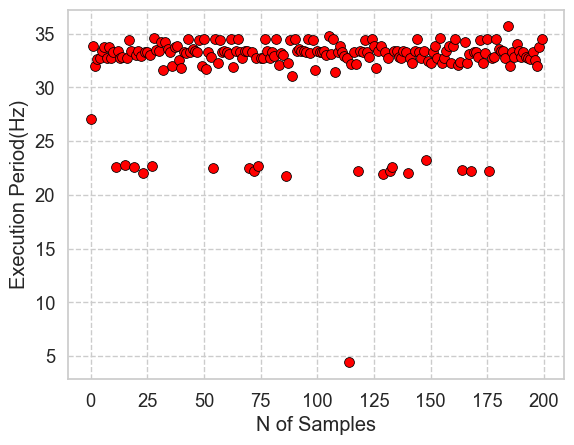

In [53]:
sns.set_theme(font_scale=1.2)
sns.set_style("whitegrid", {'grid.linestyle': '--'})

sns.scatterplot(x=np.arange(0, len(dt_time_list), 1), y=dt_time_list, edgecolor='black', color='red', s=50)

plt.xlabel('N of Samples')
plt.ylabel('Execution Period(Hz)')